# 3.7.1: Baseball Iteration

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In the last notebook, we mentioned that the coefficient of drag of a baseball is not really a constant: it changes with the velocity of the ball.  In this iteration, we'll try to replace our constant `C_d` with a function `C_d(v)` to better match this physical reality.

<br>

The cell below contains any functions you might need from notebook 3.7.1:

In [80]:
# @title
import pandas as pd
import numpy as np

def angle_to_x(mag,angle):
    theta = np.deg2rad(angle)
    x = mag * np.cos(theta)
    return x

def angle_to_y(mag,angle):
    theta = np.deg2rad(angle)
    y = mag * np.sin(theta)
    return y

def unit_vec(V, mag):
    return  V/mag

def drag_force(V, system):
    rho, C_d, area = system['rho'], system['C_d'], system['area']

    # Find the magnitude and direction of the velocity
    vel_mag = np.sqrt(V.x**2 + V.y**2)
    if vel_mag != 0:
        dir = unit_vec(V, vel_mag)
    else:
        dir = pd.Series(dict(x = 0, y = 0), dtype = float)

    # Find the magnitude of the drag force
    drag_mag = rho * vel_mag**2 * C_d * area * (1/2)

    # Define the direction of the force as opposite that of the  velocity
    # Notice that "dir" is a vector, so f_drag is vector too
    f_drag = drag_mag * -dir

    return f_drag

def change_func(t, state, system):
    x, y, vx, vy = state
    mass, g, dt = system['mass'], system['g'], system['dt']

    V = pd.Series(dict(x=vx, y=vy),dtype=float)
    a_drag = drag_force(V, system) / mass

    # Acceleration has to be defined as a vector too
    a_grav = pd.Series(dict(x=0,y=-g),dtype=float)

    A = a_grav + a_drag

    x = x + V.x*dt
    y = y + V.y*dt
    vx = vx + A.x*dt
    vy = vy + A.y*dt

    return pd.Series(dict(x=x, y=y, vx=vx, vy=vy))

def run_simulation(system, state, change_func):
    # Define the time steps
    t_array = np.arange(0, system['t_end']+1, system['dt'])
    n = len(t_array)

    # Set up a DataFrame to store the our state variables
    results = pd.DataFrame(index=t_array, columns=state.index,
                        dtype=np.float64)
    results.iloc[0] = state

    for i in range(n-1):
        t = t_array[i]
        state = change_func(t, state, system)
        results.iloc[i+1] = state
        # Test to see if the penny has hit the ground
        if state.y <= 0.0:
            results = results.dropna()
            return results

    return results

def plot_trajectory(results,label,**options):
    x = results.x.values
    y = results.y.values
    x_vs_y = pd.Series(data=y,index=x)
    x_vs_y.plot(label=label,xlabel='x position (m)',
             ylabel='y position (m)',figsize=[9,3],**options)

Now we'll run the simulation with a constant drag coefficient, so we can compare our results with a variable coefficient:

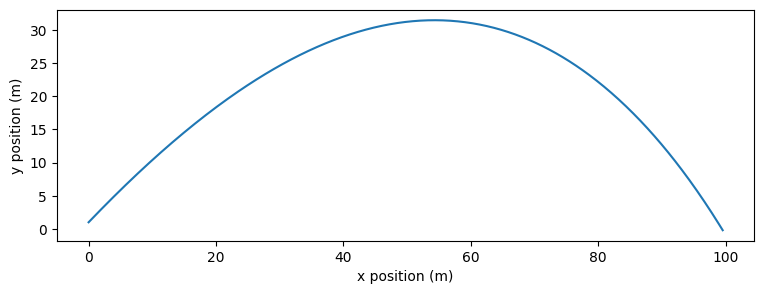

In [81]:
# Initial state variables
x = 0           # m
y = 1           # m
angle = 45      # degree
speed = 40      # m / s

# System parameters
mass = 0.145    # kg
diam = 0.073    # m
C_d = 0.33      # dimensionless
rho = 1.2       # kg/m**3
g = 9.8         # m/s**2

# Simulation parameters
t_end = 10      # s
dt = 0.01        # s

state = pd.Series(dict(x=x, y=y,
                       vx=angle_to_x(speed, angle),
                       vy=angle_to_y(speed, angle)))
system = dict(C_d=C_d, rho=rho, g=g, t_end=t_end,
                  mass=mass, area = np.pi * (diam/2)**2, dt=dt)

results = run_simulation(system, state, change_func)
plot_trajectory(results,'trajectory')

## Incorporating a Drag Function

The following figure, from Robert Adair's *The Physics of Baseball*, shows coefficient of drag as a function of velocity:

<br>

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/3_7/baseball_drag.png width = 500>


  

The data in this plot is available in the following .csv file.  We'll pull it into a DataFrame so we can access it easily:

In [82]:
filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/baseball_drag.csv'
drag_dataframe = pd.read_csv(filename, index_col = 0)
C_d_series_mph = pd.Series(index = drag_dataframe.index, data = drag_dataframe['Drag coefficient'].values)
C_d_series_mph

Velocity in mph
0.058486      0.49965
19.845000     0.49878
39.476000     0.49704
50.181000     0.48225
60.134000     0.45004
68.533000     0.40914
73.769000     0.38042
77.408000     0.36562
83.879000     0.34822
90.507000     0.33081
97.290000     0.31427
104.540000    0.30035
113.830000    0.28816
120.900000    0.28381
127.340000    0.28033
134.410000    0.28207
dtype: float64

Notice that the x-axis values ("Velocity in mph") are not regularly spaced.
 Let's create a new Series that has an index in m/s.  The drag coefficient is unitless, so there's no need to conver that

In [83]:
mph_to_mps = 0.44704
C_d_series = pd.Series(index = C_d_series_mph.index * mph_to_mps,
                       data = C_d_series_mph.values)
C_d_series

Velocity in mph
0.026146     0.49965
8.871509     0.49878
17.647351    0.49704
22.432914    0.48225
26.882303    0.45004
30.636992    0.40914
32.977694    0.38042
34.604472    0.36562
37.497268    0.34822
40.460249    0.33081
43.492522    0.31427
46.733562    0.30035
50.886563    0.28816
54.047136    0.28381
56.926074    0.28033
60.086646    0.28207
dtype: float64

Now we can plot it:

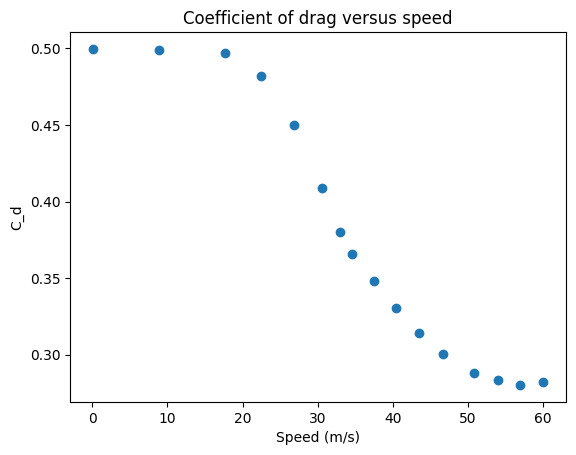

In [84]:
C_d_series.plot(label='C_d', xlabel='Speed (m/s)',
         ylabel='C_d', style='o',
         title='Coefficient of drag versus speed');

### Part 1

Clearly, we only have data points at defined speeds.  To use this data in a simulation, though, we need to be able to define the coefficient value at any speed.  In other words, we need a continuous function (rather than a discrete one) so we can access a $C_d$ value at any speed.

<br>

To do that,  we need to *interpolate* that missing data.  Notice that this is a method of guessing!  We can make our guess based on any number of principles.  We could imagine that the data lies on a straight line between two known points.  This is called *linear interpolation*,  but there are other more complex approaches to interpolation as well:

<br>

<center>
<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/3_7/interp.PNG width = 400>
</center>

 <br>

 We'll use a Numpy function called `interp()`, which performs linear interpolation.   Do a web search for "numpy interp()", and read a couple examples to see how it works.  In the cell below here, use `interp()` to find the coefficient of drag for at 30 m/s.  Consider:

 <br>

 * What are the x-axis values? How can you pull these values out of `C_d_series`?
 * What are the y-axis values?  How can you pull these values out of `C_d_series`?
 * How do you call this function?

For help with pulling the values out of `C_d_series`, see how we created `C_d_series` from `C_d_series_mph` above.  Your answer should be about 0.4161.

In [85]:
# Find the coefficient of drag at 30 m/s using np.interp()
# Could be as short as one line of code
np.interp(30, C_d_series.index, C_d_series.values)

0.4160787867185675

### Part 2

Ok, now we need to incorporate this function into our simulation.  We'll use `interp()` inside of the drag force function.  But in order to do that, we'll need to have the coefficient data available as part of `system`.  So as a first step, replace the current value for `system['C_d']` with `C_d_series`:

In [86]:
# Add C_d_series to our system (should be one line of code)
system['C_d'] = C_d_series

Important! Notice that `system['C_d']` should now be a Series rather than just a number.  So when you unpack it in `change_func`, you'll need to treat it that way!

### Part 3

Ok, now change how you treat `C_d` in the simulation.  Happily, the only time we use that variable is in `drag_force`, so just change `drag_force` so that it calculates the coefficient of drag at each time step.  The original `drag_force` is given to you here:

In [87]:
# Define the modified drag_force function here
def drag_force(V, system):
    rho, C_d, area = system['rho'], system['C_d'], system['area']

    # Find the magnitude and direction of the velocity
    vel_mag = np.sqrt(V.x**2 + V.y**2)
    if vel_mag != 0:
        dir = unit_vec(V, vel_mag)
    else:
        dir = pd.Series(dict(x = 0, y = 0), dtype = float)

    # Find the magnitude of the drag force
    C_d = np.interp(vel_mag,C_d.index, C_d.values)
    drag_mag = rho * vel_mag**2 * C_d * area * (1/2)

    # Define the direction of the force as opposite that of the  velocity
    # Notice that "dir" is a vector, so f_drag is vector too
    f_drag = drag_mag * -dir

    return f_drag

In [88]:
# Test 'drag_force_var' with the given velocity vector
# Answers should be -0.946 and -0.315
V = pd.Series(dict(x=30,y=10),dtype=float)
drag_force(V, system)

x   -0.945905
y   -0.315302
dtype: float64

### Part 4

Run the simulation, and use `plot_trajectory` to compare the two plots.

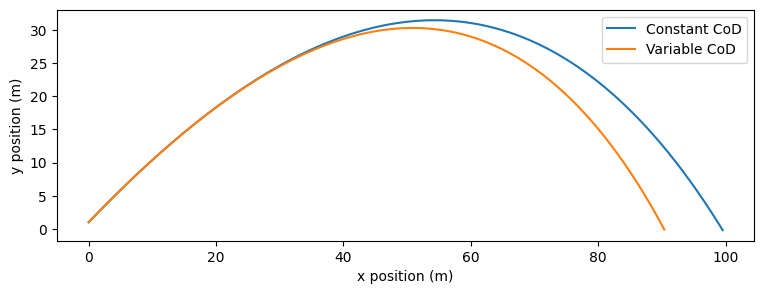

In [89]:
# Reset the state and run the simulation
state = pd.Series(dict(x=x, y=y,
                       vx=angle_to_x(speed, angle),
                       vy=angle_to_y(speed, angle)))
results_var = run_simulation(system,state,change_func)

# Plot the two results
plot_trajectory(results, 'Constant CoD',legend=True)
plot_trajectory(results_var, 'Variable CoD',legend=True)

### Part 5

Describe the results (be sure to use actual numbers!)

---

<br>

🟨 🟨  

A. What is the difference in flight time and total distance if we account for a variable coefficient of drag?









✅ ✅ Answer A here.

---

<br>

🟨 🟨

B. In answer A, you found the *absolute error* created by our earlier simplification.  Now convert these differences to a *relative error* (sometimes called *percent error*).

✅ ✅ Answer B here.

---

<br>

🟨 🟨

C. Why might relative error be a more valuable expression of error than absolute error?

✅ ✅ Answer C here.

---

<br>

🟨 🟨

D. Look back at the plot of the coefficient of drag for a baseball.  How might we have guessed that the ball would fly a shorter distance in our iterated simulation?  Remember that we used a constant value of $C_d = 0.33$ in our first simulation.

✅ ✅ Answer D here.

---

<br>

🟨 🟨

E. Below is some code that calculates and plots the velocity magnitude of the ball vs. time.  Explain the shape of this plot.  Why is the speed of the ball varying in this way?

✅ ✅ Answer E here.

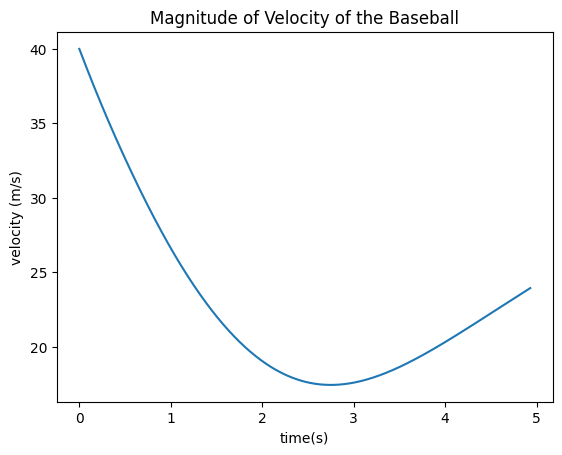

In [90]:
# Create an array that holds the speed of the ball at each time step
pythagorean_inside = results_var.vy.values**2 + results_var.vx.values**2
vel_mag = pythagorean_inside**(1/2)

# Put those values in a Series and plot them
velocity = pd.Series(data=vel_mag, index = results_var.index)
velocity.plot(title = 'Magnitude of Velocity of the Baseball',
              xlabel='time(s)', ylabel='velocity (m/s)');